In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .97
from functools import partial
try:
    env.close()
except:
    pass
if 0:
    envname = "RoboschoolInvertedPendulum-v1"
    SIZE_MULT = 1
    REWARD_MULT = 1
    N_LAYERS = 10
    NUM_HISTORY = N_HISTORY = 2
else:
    envname = "RoboschoolHumanoidFlagrun-v1"
    SIZE_MULT = 4
    REWARD_MULT = 4
    N_LAYERS = 10
    NUM_HISTORY = N_HISTORY = 3
N_EPISODES = 100
N_STEPS = 100
BATCH_SIZE = 16
DROP_RATE = .1
INIT_LEN = 100
NUM_KEEP = 100
PERCENT_CHOOSE_OPTIMAL = 2
env = gym.make(envname)
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]
N_STATE = (N_OBS + N_ACT) * 2
REWARD_IN_STATE = 0
if REWARD_IN_STATE:
    N_STATE += 2
INPUT_UNITS = N_STATE * NUM_HISTORY
STATE_DECAY = .7
TESTING_GRAD_NORMS = 0
ADV_ENABLED = 0
STORED_MODELS = {}
FCNS = {'np':{
    'concat':np.concatenate,
    'reshape':np.reshape,
    'expand':np.expand_dims
},'tf':{
    'concat':tf.concat,
    'reshape':tf.reshape,
    'expand':tf.expand_dims
}}

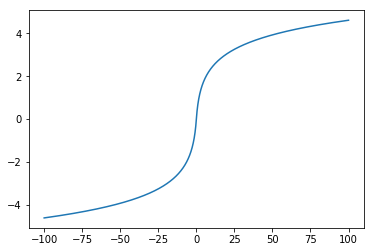

In [2]:
x = np.arange(-100, 100, .01)

y = np.log(np.abs(x)+1) * np.sign(x)

plt.plot(x, y)

In [3]:
def normalize_adv(v, mag = 1, adv_type = 0):
    size= np.sqrt(np.prod(v.shape))
    if adv_type == 0:
        return mag * v / np.abs(v).sum() * size * 3
    elif adv_type == 1:
        return mag * np.sign(v).astype(float) * .001
    elif adv_type == 2:
        sign_v = np.sign(v)
        v = np.sqrt(np.abs(v))
        v = v / v.sum() * size
        return mag * v * sign_v * 3

In [4]:

def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

class MLP:
    def __init__(self,
                x, lshapes, output_units, namebase, tanh_out = False, sigmoid = False, squeeze = True,
                reuse = False,residual = None, use_bias = True, is_train = True
                ):
        x = x * 10 - 5
        self.namebase = namebase
        self.reuse = reuse
        self.lidx = 0
        name_fcn = self.get_name
        trainable = True
        self.h = [tf.nn.crelu(tf.layers.batch_normalization(tf.layers.dense(
            x, lshapes[0], name=self.get_name(), reuse = self.reuse
        ), training = is_train,momentum = 0.9, trainable = trainable))]
        h2 = self.h[-1]
        for size in lshapes:
            new_layer = self.h[-1]
            new_layer = tf.layers.dense(new_layer, size, name = name_fcn(), reuse = reuse)
            new_layer = tf.layers.batch_normalization(new_layer, training = is_train,
                    momentum = 0.9, name = name_fcn(), reuse = reuse, trainable = trainable)
            new_layer = tf.nn.crelu(new_layer)
            new_layer = tf.layers.dense(new_layer, size, name = name_fcn(), reuse = reuse)
            new_layer = tf.layers.batch_normalization(new_layer, training = is_train,
                    momentum = 0.9, name = name_fcn(), reuse = reuse, trainable = trainable)
            new_layer = tf.nn.crelu(new_layer)
            new_layer = tf.layers.dense(new_layer, size * 2, name = name_fcn(), reuse = reuse)
            new_layer = tf.layers.batch_normalization(new_layer, training = is_train,
                    momentum = 0.9, name = name_fcn(), reuse = reuse, trainable = trainable)
            
            new_layer = new_layer + self.h[-1]
            self.h.append(tf.nn.leaky_relu(new_layer, alpha = 0.3))
            
            h2 = tf.concat(self.h, -1)#self.h[-1]
        output = tf.layers.dense(tf.nn.crelu(tf.layers.dense(
            h2, lshapes[0]//2, name = name_fcn(), reuse = self.reuse)), 
                                  output_units, name=name_fcn(), reuse = self.reuse,
            bias_initializer = tf.keras.initializers.zeros())
#         output = tf.layers.dense(
#             h2, output_units, name=name_fcn(), reuse = self.reuse,
#             bias_initializer = tf.keras.initializers.zeros())
        if output_units == 1 and squeeze:
            output = tf.squeeze(output, -1)
        self.raw_output = output
        if residual is not None:
            self.raw_output = self.raw_output + residual
        if tanh_out:
            self.output = leaky_tanh(self.raw_output)
        elif sigmoid:
            self.output = tf.nn.sigmoid(self.raw_output) * 2. - 0.5
        else:
            self.output = self.raw_output
            
#         h3 = tf.stack(self.h, 0)
        output = [tf.layers.dense(tf.nn.leaky_relu(tf.layers.dense(
            h3, lshapes[0]//2, name = name_fcn(), reuse = self.reuse)), 
                                  output_units, name=name_fcn(), reuse = self.reuse,
            bias_initializer = tf.keras.initializers.zeros()) for h3 in self.h[:-1]]
        output = tf.stack(output, 0)
        if output_units == 1 and squeeze:
            output = tf.squeeze(output, -1)
        if tanh_out:
            output = leaky_tanh(output)
        elif sigmoid:
            output = tf.nn.sigmoid(output) * 2. - 0.5
        else:
            output = output
        self.hidden_output = output
    def get_name(self):
        self.lidx = self.lidx + 1
        return self.namebase + str(self.lidx)

In [5]:

def make_maxmin(x):
    y = x.copy()
    y[maskh==0] = np.nan
    amin, amax = np.nanmin(y, (0, 1)), np.nanmax(y, (0,1))
    return amin, amax

def make_state(state, action, style = 'np'):
    together = FCNS[style]['concat']((state, action), -1)
    if style == 'tf':
        return together
#         expanded = FCNS[style]['expand'](
#             together, 1)
    else:
        expanded = FCNS[style]['expand'](
            together, 0)
    return expanded
    return FCNS[style]['reshape'](
        together, (state.shape[0], -1, state.shape[-1] + action.shape[-1]))
        
    

def accumulate_state(state, action, old_state, statedecay, style = 'np'):
    new_state = make_state(state, action, style)
    new_state_len = new_state.shape[-1]
    if style == 'tf':
        vel = new_state - old_state[:,:,0,:new_state_len]
    else:
        vel = new_state - old_state[0,:new_state_len]
    new_state = FCNS[style]['concat']((new_state, vel), -1)
    if style == 'tf':
        return FCNS[style]['concat']((tf.expand_dims(new_state, 2), old_state[:,:,:-1,:]*statedecay), 2)
    return FCNS[style]['concat']((new_state, old_state[:-1,:]*statedecay), 0)

def leaky_tanh(x):
    return tf.log(tf.abs(x)+1) * tf.sign(x)*.7
    #return tf.nn.tanh(x*30)/10 + tf.nn.tanh(x*2)/2 + tf.nn.tanh(x/20) * 2 + x * 1e-3

In [6]:

def get_grad_norm(optimizer, loss, optname):
    gvs = optimizer.compute_gradients(loss)
    grad_norm = tf.reduce_mean(
        [tf.reduce_mean(tf.square(grad)) for
         grad, var in gvs if grad is not None and optname in var.name])
    return grad_norm

In [7]:


class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [32 * SIZE_MULT] * N_LAYERS, config = None, 
                 lshapes_big = [64 * SIZE_MULT] * N_LAYERS,
                reuse = False):
        self.sess = tf.InteractiveSession(config=config)
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))
        self.statesraw = tf.placeholder(tf.float32, (None, None, N_OBS))
        self.is_train = tf.placeholder_with_default(True, (None))
        self.is_exploit = tf.placeholder(tf.float32, (None))
        self.is_exploit2d = tf.expand_dims(self.is_exploit, -1)
        self.is_exploit3d = tf.expand_dims(self.is_exploit2d, -1)
        self.statesraw_expanded = tf.expand_dims(self.statesraw, -1)
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        self.maskexpanded2 = tf.expand_dims(self.maskexpanded, -1)
        self.obs = tf.placeholder(tf.float32, (None, None, INPUT_UNITS))
        is_train = self.is_train
        self.actor = MLP(
            self.obs, lshapes_big, N_ACT, 'a_', squeeze = False, reuse = reuse,
            tanh_out = True, is_train = is_train)
        self.explorer = MLP(
            self.obs, lshapes, N_ACT, 'e_', squeeze = False, reuse = reuse,
            tanh_out = True, is_train = is_train)
        self.actions = self.actor.output
        self.explorer_actions = self.explorer.output
        self.state_value_estimator = MLP(
            self.statesraw, lshapes, 1, 'v_', reuse = reuse, sigmoid = True, is_train = is_train)
        self.state_value_estimate = self.state_value_estimator.output
        self.advantage = ((
            self.state_value_estimate[:,1:] * GAMMA + self.returns[:,:-1]) -
            self.state_value_estimate[:,:-1])
        
        
        self.actions_for_critic = tf.nn.tanh(self.actions * 10) + self.actions
        self.explorer_actions_for_critic = tf.nn.tanh(self.explorer_actions * 10) + self.explorer_actions
        self.critic_input = tf.concat((self.obs, self.actions_for_critic), -1)
        self.explorer_critic_input = tf.concat((self.obs, self.explorer_actions_for_critic), -1)
        
        
        self.advantage_estimator = MLP(
            self.critic_input, lshapes, 1, 'c_', reuse = reuse, is_train = is_train)
        self.model_estimator = MLP(
            self.critic_input, lshapes_big, N_OBS, 'm_', reuse = reuse,
            sigmoid = True, is_train = is_train
        )
        self.explorer_advantage_estimator = MLP(
            self.explorer_critic_input, lshapes, 1, 'c_', reuse = True, is_train = is_train)
        self.explorer_model_estimator = MLP(
            self.explorer_critic_input, lshapes_big, N_OBS, 'm_', reuse = True,
            sigmoid = True, is_train = is_train
        )
        self.advantage_estimate = self.advantage_estimator.output
        self.explorer_advantage_estimate = self.explorer_advantage_estimator.output
        self.model_estimate = self.model_estimator.output
        
        self.loss_input = tf.concat((
            self.critic_input, self.model_estimator.output, 
            tf.expand_dims(self.advantage_estimator.output, -1)), -1)
        self.loss_estimator = MLP(
            self.loss_input, lshapes, 2, 'l_', reuse = reuse, is_train = is_train)
        
        self.explorer_loss_input = tf.concat((
            self.explorer_critic_input, self.explorer_model_estimator.output, 
            tf.expand_dims(self.explorer_advantage_estimator.output, -1)), -1)
        self.explorer_loss_estimator = MLP(
            self.explorer_loss_input, lshapes, 2, 'l_', reuse = True, is_train = is_train)
        
        self.future_value = MLP(
            self.model_estimate, lshapes, 1, 'v_', reuse = True, sigmoid = True, is_train = is_train)
        
        self.t_vars = tf.trainable_variables()
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.e_vars = [var for var in self.t_vars if 'e_' in var.name]
        self.m_vars = [var for var in self.t_vars if 'm_' in var.name]
        self.l_vars = [var for var in self.t_vars if 'l_' in var.name]
        
        self.creg, self.areg, self.vreg, self.mreg, self.ereg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e-8
            for optvars in 
            [self.c_vars, self.a_vars, self.v_vars, self.m_vars, self.e_vars]]
        
        self.frac_not_masked = tf.reduce_mean(self.mask)
        

        self.model_state_estimate = self.model_estimator.output
        
        
        self.a_loss_critic = -tf.reduce_sum(
            self.advantage_estimator.output * self.mask)/self.frac_not_masked
        self.a_loss_model = -tf.reduce_sum(
            self.future_value.output * self.mask)/self.frac_not_masked
        
        self.v_loss_ind = tf.square(
            self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d
        self.v_loss_raw = tf.reduce_mean(self.v_loss_ind) / tf.reduce_mean(
            self.mask * self.is_exploit2d) * 1e1
        
        self.m_loss_ind = tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw[:,1:]
        ) * self.maskexpanded[:,:-1]
        self.m_loss_raw = tf.reduce_mean(self.m_loss_ind)
        
        self.e_m_loss_ind = tf.square(
            self.explorer_model_estimator.output[:,:-1] - self.statesraw[:,1:]
        ) * self.maskexpanded[:,:-1]
        
        self.e_c_loss_ind = tf.square(
            self.explorer_advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1]
        self.e_c_loss_raw = tf.reduce_mean(self.e_c_loss_ind) * 1e1
        
        self.e_l_loss = tf.reduce_mean(
            tf.square(self.explorer_loss_estimator.output[:,:-1,0] - tf.reduce_mean(self.e_m_loss_ind, -1)) *
            self.mask[:,:-1]
        ) + tf.reduce_mean(
            tf.square(
                self.explorer_loss_estimator.output[:,:-1,1] - self.e_c_loss_ind
            ) * self.mask[:,:-1]
        )
        
        self.c_loss_ind = tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1]
        self.c_loss_raw = tf.reduce_mean(self.c_loss_ind) * 1e1
        
        self.l_loss = tf.reduce_mean(
            tf.square(self.loss_estimator.output[:,:-1,0] - tf.reduce_mean(self.m_loss_ind, -1)) *
            self.mask[:,:-1]
        ) + tf.reduce_mean(
            tf.square(
                self.loss_estimator.output[:,:-1,1] - self.c_loss_ind
            ) * self.mask[:,:-1]
        )
        
        self.e_loss_critic = -tf.reduce_sum(
            self.explorer_advantage_estimator.output * self.mask)/self.frac_not_masked
        self.e_loss_loss = -self.l_loss * 10
        
        self.a_meanaction = tf.reduce_mean(
            self.actions * self.maskexpanded, [0, 1])/self.frac_not_masked
        self.a_meanactionloss = tf.reduce_mean(
            tf.square(self.a_meanaction)
        ) * 1e5 + tf.reduce_mean(
            tf.square(tf.square(self.a_meanaction))
        ) * 1e2 + tf.reduce_mean(
            tf.abs(self.a_meanaction)
        ) * 1e0
        
        self.e_meanaction = tf.reduce_mean(
            self.explorer_actions * self.maskexpanded, [0, 1])/self.frac_not_masked
        self.e_meanactionloss = tf.reduce_mean(
            tf.square(self.e_meanaction)
        ) * 1e5 + tf.reduce_mean(
            tf.square(tf.square(self.e_meanaction))
        ) * 1e2 + tf.reduce_mean(
            tf.abs(self.e_meanaction)
        ) * 1e0
        
        
        self.a_mse = tf.reduce_mean((
            tf.square(self.actor.raw_output) * 1e2 + tf.square(tf.square(self.actor.raw_output)) * 1.
            ) * self.maskexpanded)/tf.reduce_mean(self.maskexpanded)
        
        
        self.e_mse = tf.reduce_mean((
            tf.square(self.explorer.raw_output) * 1e2 + tf.square(tf.square(self.explorer.raw_output)) * 1.
            ) * self.maskexpanded)/tf.reduce_mean(self.maskexpanded)
        
        if 0:
            optimizer = tf.train.RMSPropOptimizer
            self.critic_opt = optimizer(self.lr, momentum= .8)
            self.value_opt = optimizer(self.lr, momentum= .8)
            self.actor_opt = optimizer(self.lr, momentum= .8)
            self.model_opt = optimizer(self.lr, momentum= .8)
            self.explorer_opt = optimizer(self.lr, momentum= .8)
            self.loss_opt = optimizer(self.lr, momentum= .8)
        else:
            self.opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        
        
        self.v_loss =  self.v_loss_raw + self.vreg
        self.m_loss = self.m_loss_raw + self.mreg
        self.c_loss =  self.c_loss_raw + self.creg
        self.aregtotal = self.areg + self.a_mse + self.a_meanactionloss
        self.a_loss_raw = self.a_loss_critic + self.a_loss_model
        self.a_loss = self.a_loss_raw + self.aregtotal
        self.e_loss = self.e_loss_critic - self.e_l_loss
        self.l_loss_minimize = self.l_loss
        self.e_loss_minimize = self.e_loss + \
            self.e_mse + self.ereg + self.e_meanactionloss
        self.a_loss_minimize = self.a_loss
        
        
        
        self.c_loss_minimize = self.c_loss + tf.reduce_mean(
            tf.square(self.advantage_estimator.hidden_output[:,:,:-1] - tf.expand_dims(self.advantage, 0)
                 )) * tf.expand_dims(self.mask[:,:-1], 0) * tf.reshape(
            tf.range(N_LAYERS, dtype = tf.float32)/(N_LAYERS * 2) + .1, (-1, 1, 1))
        
        
#         self.v_loss_ind = tf.square(
#             self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d
#         self.v_loss_raw = tf.reduce_mean(self.v_loss_ind) / tf.reduce_mean(
#             self.mask * self.is_exploit2d) * 1e1
        
        
        self.v_loss_minimize = self.v_loss + tf.reduce_mean(
            tf.square(self.state_value_estimator.hidden_output - tf.expand_dims(self.returnsdecayed, 0)
                 )) * tf.expand_dims(self.mask, 0) * tf.expand_dims(self.is_exploit2d, 0) * tf.reshape(
            tf.range(N_LAYERS, dtype = tf.float32)/(N_LAYERS * 2) + .1, (-1, 1, 1))
        
        self.m_loss_minimize = self.m_loss + tf.reduce_mean(
            tf.square(self.model_estimator.hidden_output[:,:,:-1] - tf.expand_dims(self.statesraw[:,1:], 0)
                 )) * tf.expand_dims(self.maskexpanded[:,:-1], 0) * tf.reshape(
            tf.range(N_LAYERS, dtype = tf.float32)/(N_LAYERS * 2) + .1, (-1, 1, 1, 1))
        # + self.grad_norm_m + self.grad_m_1
        
        
        self.v_obs_grad = tf.gradients(self.v_loss_minimize, self.statesraw)
        self.c_obs_grad = tf.gradients(self.c_loss_minimize, self.critic_input)
        self.m_obs_grad = tf.gradients(self.m_loss_minimize, self.critic_input)
        self.a_obs_grad = tf.gradients(self.a_loss_minimize, self.obs)
        self.e_obs_grad = tf.gradients(self.e_loss_minimize, self.obs)
        self.l_obs_grad = tf.gradients(self.l_loss_minimize, self.loss_input)
        
        if TESTING_GRAD_NORMS:
            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty, self.a_mse
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.opt, self.a_loss_minimize, var_list = self.a_vars)
        self.mopt, self.m_norm = apply_clipped_optimizer(
            self.opt, self.m_loss_minimize, var_list = self.m_vars)
        self.eopt, self.e_norm = apply_clipped_optimizer(
            self.opt, self.e_loss_minimize, var_list = self.e_vars)
        self.lopt, self.l_norm = apply_clipped_optimizer(
            self.opt, self.l_loss_minimize, var_list = self.l_vars)

    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs, exploit = True):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        if exploit:
            act = self.actions
        else:
            act = self.explorer_actions
        a = self.sess.run(
            act, feed_dict={
                self.obs:(obs/shdiff) - shmin_g_e,
                self.is_train:False
            })
        return a[0][0]  # return first in batch



config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
# env.close()


# env = gym.make(envname)

In [ ]:
if TESTING_GRAD_NORMS:
    self.actor_current_mult = np.ones_like(self.actor_current_mult,dtype=np.float32)
    self.critic_current_mult = np.ones_like(self.critic_current_mult,dtype=np.float32)

In [ ]:

#         self.advantage = ((
#             self.stateraw_value_estimate[:,1:] * GAMMA + self.returns) -
#             self.state_value_estimate[:,:-1])

In [ ]:

ah, sh, shraw, rh, rdecayedh, maskh = [
    np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
isexploit = []
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
exploit = 0
printfreq = 20
obj_fname = envname + str(PERCENT_CHOOSE_OPTIMAL) + 'saveobjs_unguided.pkl'
tffile = "tmp/" + envname + str(PERCENT_CHOOSE_OPTIMAL) + "unguided_trained.ckpt"
import pickle

In [ ]:
ongoing = 0
sess.run(tf.global_variables_initializer())

In [ ]:
def get_feed_dict(batch_size, forced_hist, sample_flat):
    num_hist = ah.shape[0]
    if num_hist >  batch_size:
        if sample_flat:
            probability = np.ones(maskh.shape[0])
        else:
            probability = np.square(np.arange(maskh.shape[0])/1000 + .01)
        if forced_hist:
            probability = probability[:-forced_hist]
        probability = np.square(probability)
        probability = probability / probability.sum()
        rnd = np.random.choice(
                num_hist - forced_hist, batch_size - forced_hist, 
                replace=False, p=probability)
        if forced_hist:
            samples = np.concatenate((rnd,
                np.arange( num_hist - forced_hist, num_hist)))
        else:
            samples=rnd
    else:
        samples = np.random.choice(num_hist, num_hist, replace=False)
    actions, states, statesraw, returns, returnsdecayed, mask, exploit = [
        v[samples] for v in [ah, sh, shraw, rh,rdecayedh, maskh, np.array(isexploit)]]
    returns = (returns - vmin_g_e) / vdiff
    statesrawactive = (statesraw- shrawmin_g_e) / shrawdiff
    rd = (returnsdecayed - vmin_g_e) / vdiff
    obs = (states - shmin_g_e)/shdiff

    returnsmasked, rdmasked = [
        v[mask.astype(bool)] for v in 
    [returns, rd]]

    statesmasked, obsmasked = [
        v[np.tile(np.expand_dims(mask, -1), [1,1,v.shape[-1]]).astype(bool)] for v in 
    [statesrawactive, obs]]

    feed_dict={
                self.returns:returns,
                self.statesraw: statesrawactive,
                self.returnsdecayed:rd,
                self.lr: .0002,# / np.power(ep + 20, .4),
                self.mask:mask,
                self.obs: obs,
                self.is_exploit:exploit,
                self.actions:actions
    }
    return feed_dict

In [ ]:
class Trainer:
    def __init__(self, opt, grad, loss, inpt, pi, name = ''):
        self.opt = opt
        self.grad = grad
        self.loss = loss
        self.inpt = inpt
        self.steps = 0
        self.loss_mean = [0]
        self.loss_pre_mean = [0]
        self.diff_loss_mean = [0]
        self.name = name
    def step(self, feed_dict):
        if self.name in ['a', 'e']:
            del feed_dict[pi.actions]
        grad, loss_pre, inpt = sess.run([self.grad, self.loss, self.inpt], feed_dict)
        n_grad = normalize_adv(grad[0], mag = 1., adv_type = 1)
        feed_dict[self.inpt] = inpt + n_grad
        _, loss = sess.run([self.opt, self.loss], feed_dict)
        diff = loss - loss_pre
        self.track_losses(loss, loss_pre, diff)
        if self.steps % 10 == 9:
            print(self.name, 'loss', np.mean(self.loss_mean).round(3), 
                  'loss_pre', np.mean(self.loss_pre_mean).round(3), 
                  'loss_diff', np.mean(self.diff_loss_mean).round(3))
        self.steps += 1
        return loss, loss_pre
    def track_losses(self, loss, loss_pre, diff):
        self.loss_mean.append(loss)
        self.loss_pre_mean.append(loss_pre)
        self.diff_loss_mean.append(diff)
        self.loss_mean, self.loss_pre_mean, self.diff_loss_mean = [
            v[-10:] for v in [self.loss_mean, self.loss_pre_mean, self.diff_loss_mean]]

In [ ]:
model_trainer = Trainer(pi.mopt, pi.m_obs_grad, pi.m_loss, pi.critic_input, pi, name = 'm')
critic_trainer = Trainer(pi.copt, pi.c_obs_grad, pi.c_loss, pi.critic_input, pi, name = 'c')
loss_trainer = Trainer(pi.lopt, pi.l_obs_grad, pi.l_loss, pi.loss_input, pi, name = 'l')
value_trainer = Trainer(pi.vopt, pi.v_obs_grad, pi.v_loss, pi.statesraw, pi, name = 'v')
actor_trainer = Trainer(pi.aopt, pi.a_obs_grad, pi.a_loss, pi.obs, pi, name = 'a')
explorer_trainer = Trainer(pi.eopt, pi.e_obs_grad, pi.e_loss_minimize, pi.obs, pi, name = 'e')

In [ ]:
def train_all(batch_size = None, forced_hist = 0, sample_flat = True, n_steps = None):
    if n_steps is None:
        n_steps = N_STEPS
    if batch_size is None:
        batch_size = BATCH_SIZE
    for mdl in [model_trainer, value_trainer, critic_trainer, loss_trainer, actor_trainer, explorer_trainer]:
        for _ in range(n_steps):
            fd= get_feed_dict(batch_size, forced_hist, sample_flat)
            mdl.step(fd)

In [ ]:
trained = 0
ongoing = 0

In [ ]:
trained, ongoing

(0, 0)

In [ ]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit,
             shrawmin_g_e, shrawmax_g_e,shmin_g_e, shmax_g_e, vmin_g_e, vmax_g_e, shrawdiff, shdiff, vdiff

            ], f)
    trained = 1

In [ ]:

# with open(obj_fname, "rb") as f:
#     ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit, \
#             shrawmin_g_e, shrawmax_g_e,shmin_g_e, shmax_g_e, vmin_g_e, \
#             vmax_g_e, shrawdiff, shdiff, vdiff = pickle.load(f)

In [ ]:
LEAVE_ALONE = 0

In [ ]:

if not LEAVE_ALONE:
    [[shrawmin_g, shrawmax_g],
        [shmin_g, shmax_g],
        [vmin_g, vmax_g]] = [[
        np.ones(i) * 1000, np.zeros(i) * -1000] for i in [N_OBS, N_STATE * N_HISTORY, 1]]
    if trained:
        try:
            saver.restore(sess, tffile)
            with open(obj_fname, "rb") as f:
                ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit, \
                    shrawmin_g_e, shrawmax_g_e,shmin_g_e, shmax_g_e, vmin_g_e, \
                    vmax_g_e, shrawdiff, shdiff, vdiff = pickle.load(f)
            print('restored from save file')
            reinit = 1
        except:
            print('no save file detected')
            trained = 0
            reinit = 0
    else:

        reinit = 0
        [[shrawmin_g, shrawmax_g],
            [shmin_g, shmax_g],
            [vmin_g, vmax_g]] = [[
            np.ones(i) * 1000, np.zeros(i) * -1000] for i in [N_OBS, N_STATE * N_HISTORY, 1]]
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-NUM_KEEP:], sh[-NUM_KEEP:], shraw[-NUM_KEEP:],
                 rh[-NUM_KEEP:], rdecayedh[-NUM_KEEP:], maskh[-NUM_KEEP:], ep, globalframes, isexploit[-NUM_KEEP:], 
                shrawmin_g_e, shrawmax_g_e,shmin_g_e, shmax_g_e, vmin_g_e, 
                vmax_g_e, shrawdiff, shdiff, vdiff
                ], f)
    if ep < 10000 and ep > 1:
        reinit = 0
        shrawmin, shrawmax = make_maxmin(shraw)
        shmin, shmax = make_maxmin(sh)
        vmin, vmax = make_maxmin(rdecayedh)
        shrawmin_g, shmin_g, vmin_g = [
            np.minimum(g, n) for g, n in zip(
                [shrawmin_g, shmin_g, vmin_g], [shrawmin, shmin, vmin])]
        shrawmax_g, shmax_g, vmax_g = [
            np.maximum(g, n) for g, n in zip(
                [shrawmax_g, shmax_g, vmax_g], [shrawmax, shmax, vmax])]

        [shrawmin_g_e, shrawmax_g_e,shmin_g_e, shmax_g_e] = [
            np.reshape(v, (1, 1, -1)) for v in [shrawmin_g, shrawmax_g,shmin_g, shmax_g]]
        vmin_g_e, vmax_g_e = [np.reshape(v, (1, 1)) for v in [vmin_g, vmax_g]]

        shrawdiff = shrawmax_g_e - shrawmin_g_e
        shdiff = shmax_g_e - shmin_g_e
        vdiff = vmax_g_e - vmin_g_e
    trained = 1
    ongoing = 1
    
    an, sn, snraw, rn, rdecayedn, maskn = [
        np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obsraw = obs
    snraw = np.concatenate((snraw, obs.reshape(1, -1)), 0)
    obs = np.concatenate((obs, np.zeros(N_ACT)))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    rn = [0]
    done_ctr = 0
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    if exploit or ep < 5:
        exploit = 0
    else:
        exploit = 1
        if np.random.rand() > .5:
            exploit = 0
    while 1:
        step_num += 1
        if ep < 5:
            a = np.random.randn(N_ACT) * .1
        else:
            if exploit:
                a = pi.act(obs_mat.flatten(), exploit = exploit)
            else:
                if np.random.rand() < .4:
                    a = pi.act(obs_mat.flatten(), exploit = exploit)
                elif np.random.rand() < .6:
                    a = pi.act(obs_mat.flatten(), exploit = 1)
                else:
                    a = np.random.randn(N_ACT) * 1.
        an = np.concatenate((an, a[None,:]), 0)
        snraw = np.concatenate((snraw, obsraw[None,:]), 0)
        last_obs = obs
        obs, r, done, _ = env.step(a)
        obsraw = obs
        r = r + 1 * REWARD_MULT

        obs_mat = accumulate_state(
            obs, a, obs_mat, STATE_DECAY, style = 'np')
        
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        if ep > INIT_LEN:
            still_open = env.render("human")
        else:
            still_open = 1
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    if ep < INIT_LEN:
        a = np.random.randn(N_ACT)
    else:
        a = pi.act(obs_mat.flatten())
    an = np.concatenate((an, a[None,:]), 0)
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20 * REWARD_MULT
    rn[-2] = rn[-2] - 10 * REWARD_MULT
    rn[-3] = rn[-3] - 5 * REWARD_MULT
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, shraw, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, snraw, rn,rdecayedn, maskn]]
        isexploit = [exploit]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh, shraw = [get_updated_h(h, n, 1) for  h, n in zip(
            [ah, sh, shraw], [an, sn, snraw])]
        
        rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [rh, rdecayedh, maskh], [rn, rdecayedn, maskn])]
        isexploit.append(exploit)
    if ep % 1 == 0 and ep > INIT_LEN:
        ah, sh, shraw, rh,rdecayedh, maskh, isexploit = [
            v[-NUM_KEEP:] for v in [ah, sh, shraw, rh,rdecayedh, maskh, isexploit]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = BATCH_SIZE
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
    if ep % N_EPISODES == 0 and ep > 0:
        print(np.mean(globalframes[-100:]))
        train_all()
        ysmoothed = gaussian_filter1d(globalframes, sigma=4)
        plt.plot(ysmoothed)
        plt.show()

score 86.71950931666713  frames 20
saved at epoch 100


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
m loss 0.186 loss_pre 0.177 loss_diff 0.009
m loss 0.245 loss_pre 0.229 loss_diff 0.015
m loss 0.161 loss_pre 0.15 loss_diff 0.011
m loss 0.121 loss_pre 0.112 loss_diff 0.009
m loss 0.102 loss_pre 0.095 loss_diff 0.007
m loss 0.078 loss_pre 0.073 loss_diff 0.005
m loss 0.069 loss_pre 0.065 loss_diff 0.004
m loss 0.062 loss_pre 0.059 loss_diff 0.003
m loss 0.051 loss_pre 0.048 loss_diff 0.003
m loss 0.047 loss_pre 0.045 loss_diff 0.002
v loss 2.485 loss_pre 1.773 loss_diff 0.712
v loss 5.157 loss_pre 4.792 loss_diff 0.365
v loss 4.491 loss_pre 4.087 loss_diff 0.404
v loss 4.283 loss_pre 3.796 loss_diff 0.487
v loss 3.228 loss_pre 2.738 loss_diff 0.491
v loss 2.622 loss_pre 2.156 loss_diff 0.466
v loss 2.405 loss_pre 1.962 loss_diff 0.443
v loss 1.656 loss_pre 1.303 loss_diff 0.353
v loss 1.806 loss_pre 1.48 loss_diff 0.326
v loss 1.787 loss_pre 1.494 loss_diff 0.293
c loss 42.872 loss_pre 32.57 loss_diff 10.303
c loss 498.824 loss_pre 461.099 loss_diff 37.725
c loss 133.895 loss_pre

In [ ]:

N_EPISODES = 4
N_STEPS = 1000
BATCH_SIZE = 4

In [ ]:
ep

In [ ]:
ep = 10000

In [ ]:
sess.run(self.model_estimator.hidden_output[:,:-1], feed_dict).shape

In [ ]:
tf.reduce_mean(
            tf.square(self.model_estimator.hidden_output[:,:-1] - tf.expand_dims(self.statesraw[:,1:], -1)
                 )) * tf.expand_dims(self.maskexpanded[:,:-1], -1) * tf.reshape(
            tf.range(N_LAYERS, dtype = tf.float32)/(N_LAYERS * 2) + .1, (1, 1, 1, -1))

In [ ]:
ep = 1002

In [ ]:
feed_dict = train(actor = True, value = True, n_steps = 1)

In [ ]:
feed_dict[self.obs][:,:7,:].min(0).min(0)

In [ ]:
sess.run(self.critic_input[:,:7,0], feed_dict).min()

In [ ]:
INIT_LEN

In [ ]:
ah[-11::2,5:10].std()

In [ ]:
isexploit[-5:]

In [ ]:
sess.run(self.loss_estimator.h[0], feed_dict)

In [ ]:
tf.gradients(self.loss_estimator.output, self.loss_input)

In [ ]:

        self.l_loss = tf.reduce_mean(
            tf.square(self.loss_estimator.output[:,:-1,0] - tf.reduce_mean(self.m_loss_ind, -1)) * self.mask[:,:-1]
        ) + tf.reduce_mean(
            tf.square(
                self.loss_estimator.output[:,:-1,1] - self.c_loss_ind
            ) * self.mask[:,:-1]
        )

In [ ]:
sess.run(tf.reduce_mean(
            tf.square(self.loss_estimator.output[:,:-1,0] - tf.reduce_mean(self.m_loss_ind, -1)) * self.mask[:,:-1]
        ) + tf.reduce_mean(
            tf.square(
                self.loss_estimator.output[:,:-1,1] - self.c_loss_ind
            ) * self.mask[:,:-1]
        ), feed_dict)

In [ ]:
sess.run(tf.reduce_mean(self.c_loss_ind, -1), feed_dict).shape
        self.l_loss = tf.reduce_mean(
            tf.square(self.loss_estimator.output[:,:-1,0] - tf.reduce_mean(self.m_loss_ind, -1)) * self.mask[:,:-1]
        ) + tf.reduce_mean(
            tf.square(
                self.loss_estimator.output[:,:-1,1] - self.c_loss_ind
            ) * self.mask[:,:-1]
        )

In [ ]:
ep = 220

In [ ]:
mvars2 = sess.run(self.m_vars)

In [ ]:
for m1, m2 in zip(mvars, mvars2):
    print(np.square(m1 - m2).mean())

In [ ]:
N_STATE * N_HISTORY

In [ ]:
self.m_vars

In [ ]:
sess.run(self.model_estimate, feed_dict)[0,:10,:]

In [ ]:
sess.run(self.statesraw[:,1:], feed_dict)[0,:10]

In [ ]:
sess.run(self.critic_input, feed_dict)[:,5:10]

In [ ]:
feed_dict[self.lr] = .01

In [ ]:
feed_dict = get_feed_dict(4, 0, True)

In [ ]:
for _ in range(100):
    print(sess.run([self.mopt, self.m_loss], feed_dict))

In [ ]:
sess.run(self.statesraw[:,1:], feed_dict)[:,:10, 2]

In [ ]:
normalize_adv(sess.run(self.m_obs_grad, feed_dict), adv_type = 1)[:,:10]

In [ ]:
sess.run(self.model_estimate, feed_dict)[:,:10]

In [ ]:
N_ACT + N_OBS

In [ ]:
maskh.sum(0)

In [ ]:
sess.run(self.critic_input, feed_dict)[:,:7][:,0]

In [ ]:
sess.run(self.model_estimate, feed_dict)[2,5:10]

In [ ]:
sess.run(self.statesraw[:,1:], feed_dict)[2,5:10]

In [ ]:
sess.run(self.model_estimate, feed_dict)[2,5:10]

In [ ]:
sess.run(self.actions, feed_dict)[:,5:10]

In [ ]:
feed_dict[self.lr]

In [ ]:
feed_dict[self.lr]# = .0005

In [ ]:
for _ in range(200):
    print(sess.run([self.mopt, self.m_loss], feed_dict))

In [ ]:
ep = 560

In [ ]:
feed

In [ ]:
for _ in range(30):
    train(actor = True, value = True, n_steps = 4)